# APS360 Group Project

In [45]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
from torch.utils.data import SubsetRandomSampler
from torch.utils.data.dataloader import default_collate
import matplotlib.pyplot as plt
import os

In [46]:
global device
print("Cuda Available:", torch.cuda.is_available())
device = "cuda" if torch.cuda.is_available() else "cpu"

Cuda Available: False


In [47]:
FONT_DATASET_PATH = "./fonts_image_dataset"

# Convert the images to tensors and normalize them
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), transforms.Grayscale(num_output_channels=1)])
fonts_dataset = torchvision.datasets.ImageFolder(root = FONT_DATASET_PATH, transform=transform)
    
num_classes = len(fonts_dataset.classes)
print(num_classes)
    
# Create a list of indices for all the images in the dataset
dataset_size = len(fonts_dataset)
indices = list(range(dataset_size))
np.random.seed(0)
np.random.shuffle(indices)
np.savetxt("indices", indices)
# Split the indices into 60% Training 20% Validation 20% Testing. We need most of the data for training the network, but we must also set aside a bit for validation to fine tune the network, and test the network at the very end.
split1 = int(0.6 * dataset_size)
split2 = int(0.8 * dataset_size)
train_indices, val_indices, test_indices = indices[:split1], indices[split1:split2], indices[split2:]
# Create a sampler for the training, validation, and testing sets
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)
test_sampler = SubsetRandomSampler(test_indices)

FONT_DATASET_PATH2 = "./fonts_image_dataset_no_rotations"

# Dataset 2
fonts_dataset2 = torchvision.datasets.ImageFolder(root = FONT_DATASET_PATH2, transform=transform)

def load_dataset(fonts_dataset, batch_size = 32):
    
    def custom_collate_fn(batch):
    
        # Use the default collate function to batch the data (images)
        batch = default_collate(batch)
        images, labels = batch
        
        # Apply one-hot encoding to the labels
        labels = F.one_hot(labels, num_classes=num_classes)

        return images, labels

    # Create the dataloaders for the training, validation, and testing sets
    train_loader = torch.utils.data.DataLoader(fonts_dataset, batch_size=batch_size,sampler=train_sampler,collate_fn=custom_collate_fn)
    val_loader = torch.utils.data.DataLoader(fonts_dataset, batch_size=batch_size,sampler=val_sampler,collate_fn=custom_collate_fn)
    test_loader = torch.utils.data.DataLoader(fonts_dataset, batch_size=batch_size,sampler=test_sampler,collate_fn=custom_collate_fn)

    print("Done Loading Data")

    return train_loader, val_loader, test_loader, fonts_dataset.classes


51


In [48]:
def total_error(outputs, labels):
    
    # Find the indices of the max values
    _, indices = torch.max(outputs, dim=1, keepdim=True)

    # Create a tensor of zeros with the same shape as x
    zeros = torch.zeros_like(outputs)

    # Set the max values to 1
    zeros.scatter_(1, indices, 1)
    
    return (zeros != labels).any(dim=1).float().sum()

def evaluate(net, loader, AE = False, output_loader=None):

    net.eval()
    
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    
    if AE == True:
        criterion = nn.MSELoss()
        output_loader_iter = iter(output_loader)
    else:
        criterion = nn.CrossEntropyLoss()

    with torch.no_grad():

        for i, (inputs, labels) in enumerate(loader, 0):
            inputs, labels = inputs.to(device), labels.to(device)
            if AE:
                inputs2, labels2 = next(output_loader_iter)
                inputs2, labels2 = inputs2.to(device), labels2.to(device)
            
            # Forward pass
            outputs = net(inputs)
            
            # Calculate the statistics
            if AE == True:
                total_loss += criterion(outputs, inputs2).item()
            else:  
                total_err += total_error(outputs, labels)
                total_loss += criterion(outputs, labels.float()).item()
            total_epoch += len(labels)

    loss = float(total_loss) / (i + 1)
    if AE == True:
        return loss
    else:
        err = float(total_err) / total_epoch
        return err, loss
    
def train_net(net, model_name, dataset_path = FONT_DATASET_PATH, BATCH_SIZE = 128, learning_rate = 0.01, num_epochs = 30, patience = None, AE = False):

    torch.cuda.empty_cache()

    torch.manual_seed(0)
    torch.cuda.manual_seed(0)
    train_loader, val_loader, test_loader, classes = load_dataset(fonts_dataset, batch_size = BATCH_SIZE)

    if AE:
        train_loader2, val_loader2, test_loader2, classes = load_dataset(fonts_dataset, batch_size = BATCH_SIZE)

    # Create the directory to store model if it does not exist
    if not os.path.exists(model_name):
      os.makedirs(model_name)
    
    # Set the seed for reproducibility
    torch.manual_seed(0)
    torch.cuda.manual_seed(0)
    
    if AE == True:
        criterion = nn.MSELoss()
    else:
        criterion = nn.CrossEntropyLoss()
        
    optimizer = optim.AdamW(net.parameters(), lr=learning_rate,weight_decay=1e-3)

    if patience != None:
        num_epochs = 60
    
    # Set up some numpy arrays to store the loss/error rate
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    
    min_validation_loss = 10000000
    min_validation_err = 10000000
    stop_counter = 0
    
    print("Starting Training")
    
    # Train the network
    for epoch in range(num_epochs):
        
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0
        
        cur_loader = train_loader if not AE else train_loader2
        if AE:
            train_loader_iter = iter(train_loader)
        
        for i, (inputs, labels) in enumerate(cur_loader, 0):
            inputs, labels = inputs.to(device), labels.to(device)
            
            if AE:
                inputs2, labels2 = next(train_loader_iter)
                inputs2, labels2 = inputs2.to(device), labels2.to(device)

            
            net.train()
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass, backward pass, and optimize
            outputs = net(inputs)
            
            if AE == True:
                loss = criterion(outputs, inputs)
            else:
                loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()

            net.eval()
            
            # Calculate the statistics
            if AE == False:
                total_train_err += total_error(outputs, labels)
            total_train_loss += loss.item()
            total_epoch += len(labels)
            
        train_loss[epoch] = float(total_train_loss) / (i+1)
        
        if AE == True:
            val_loss[epoch] = evaluate(net, val_loader2, AE, output_loader=val_loader)
            # Print the statistics
            print(f"Epoch {epoch + 1}: Train loss: {train_loss[epoch]} | Validation loss: {val_loss[epoch]}")
        else:
            train_err[epoch] = float(total_train_err) / total_epoch
            val_err[epoch], val_loss[epoch] = evaluate(net, val_loader, AE)
            # Print the statistics
            print(f"Epoch {epoch + 1}: Train err: {train_err[epoch]}, Train loss: {train_loss[epoch]} | Validation err: {val_err[epoch]}, Validation loss: {val_loss[epoch]}")
            # Write the err into CSV file for plotting later
            np.savetxt(f"{model_name}/val_err.csv", val_err)
            np.savetxt(f"{model_name}/train_err.csv", train_err)
                
        
        # Write the loss into CSV file for plotting later
        np.savetxt(f"{model_name}/train_loss.csv", train_loss)
        np.savetxt(f"{model_name}/val_loss.csv", val_loss)
        
        # Save the best model
        if AE == True:
            if val_loss[epoch] <= min_validation_loss:
                min_validation_loss = val_loss[epoch]
                torch.save(net.state_dict(), f"{model_name}/best_model")
                stop_counter = 0
            else:
                stop_counter += 1
        else:
            if val_err[epoch] <= min_validation_err:
                min_validation_err = val_err[epoch]
                torch.save(net.state_dict(), f"{model_name}/best_model")
                stop_counter = 0
            else:
                stop_counter += 1
        
        if patience != None and stop_counter >= patience:
            break
        

    print('Finished Training')
    net.load_state_dict(torch.load(f"{model_name}/best_model"))
    
    if AE == False:
        test_err, test_loss = evaluate(net, test_loader, criterion)
        print(f"Test error: {test_err}, Test loss: {test_loss}")   

In [49]:
def plot_training_curve(path):
    train_err = np.loadtxt("{}/train_err.csv".format(path))
    val_err = np.loadtxt("{}/val_err.csv".format(path))
    train_loss = np.loadtxt("{}/train_loss.csv".format(path))
    val_loss = np.loadtxt("{}/val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    num_epochs = len(train_err)
    plt.plot(range(1,num_epochs+1), train_err, label="Train")
    plt.plot(range(1,num_epochs+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,num_epochs+1), train_loss, label="Train")
    plt.plot(range(1,num_epochs+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()  

def visualize_output(net, num_images = 5, dataset_path = FONT_DATASET_PATH):

    # Load the data
    train_loader, val_loader, test_loader, classes = load_dataset(fonts_dataset, batch_size = num_images)
    dataiter = iter(test_loader)
    images, labels = next(dataiter)
    net = net.to("cpu")
    # Get ground truth labels
    ground_truth = [classes[np.argmax(labels[j], axis=0)] for j in range(num_images)]

    # Get model predictions
    outputs = net(images)
    outputs = np.argmax(outputs.detach().numpy(), axis=1)    
    predicted = [classes[outputs[j]] for j in range(num_images)]
    
    fig, axs = plt.subplots(1, num_images, figsize=(20, 20))

    # Print Images
    for i in range(num_images):
        img = images[i]
        npimg = img.numpy()

        axs[i].imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')
        axs[i].set_yticklabels([])
        axs[i].set_xticklabels([])
        axs[i].set_xticks([])
        axs[i].set_yticks([])

        axs[i].set_title(f"Predicted: {predicted[i]} \n Ground Truth: {ground_truth[i]}")
    plt.show()
    net = net.to(device)
    
def visualize_autoencoder_output(net, num_images = 5, dataset_path = FONT_DATASET_PATH):
    # Load the data
    train_loader, val_loader, test_loader, classes = load_dataset(fonts_dataset, batch_size = num_images)
    dataiter = iter(test_loader)
    images, labels = next(dataiter)
    net = net.to("cpu")
    
    # Get model predictions
    outputs=net(images)
    
    # Reformat
    outputs = outputs.cpu().detach().numpy()
    images = images.cpu().detach().numpy()
    
    fig, axs = plt.subplots(2, num_images, figsize=(20, 10))

    for i in range(num_images):
        
        for j in range(2):
            img = images[i] if j == 0 else outputs[i]

            axs[j,i].imshow(np.transpose(img, (1, 2, 0)), cmap='gray', vmin=-1,vmax=1)
            axs[j,i].set_yticklabels([])
            axs[j,i].set_xticklabels([])
            axs[j,i].set_xticks([])
            axs[j,i].set_yticks([])
    fig.tight_layout()
    plt.show()
    net = net.to(device)



## Baseline Model

In [50]:
class BaselineModel(nn.Module):
    def __init__(self):
        super(BaselineModel, self).__init__() 
        self.conv1 = nn.Conv2d(1, 5, 3) 
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, 3)
        self.conv3 = nn.Conv2d(10, 20, 3)
        self.fc = nn.Linear(26*26*20, 51) #change based on num of classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 26*26*20)

        x = self.fc(x)

        return x

In [51]:
baseline_model = BaselineModel()
baseline_model = baseline_model.to(device)

train_net(baseline_model, "baseline_model", learning_rate = 0.005, num_epochs = 15)

Done Loading Data
Starting Training


KeyboardInterrupt: 

## Primary Model

In [ ]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 2, 1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, 2, 1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 3, 2, 1)
        self.bn3 = nn.BatchNorm2d(128)

    def forward(self, x):
        x = self.bn1(F.relu(self.conv1(x)))    # 32 x 112 x 112
        x = self.bn2(F.relu(self.conv2(x)))    # 64 x 56 x 56
        x = self.bn3(F.relu(self.conv3(x)))    # 128 x 28 x 28

        return x

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()

        self.conv4 = nn.ConvTranspose2d(128, 64, 3, 2, 1, 1)
        self.bn4 = nn.BatchNorm2d(64)
        self.conv5 = nn.ConvTranspose2d(64, 32, 3, 2, 1, 1)
        self.bn5 = nn.BatchNorm2d(32)
        self.conv6 = nn.ConvTranspose2d(32, 1, 3, 2, 1, 1)

    def forward(self, x):

        x = self.bn4(F.relu(self.conv4(x)))
        x = self.bn5(F.relu(self.conv5(x)) )
        x = self.conv6(x)
        
        return x

class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)

        return x

#class PrimaryModel(nn.Module):
    # def __init__(self, encoder, decoder):
    #     super(PrimaryModel, self).__init__()
    #     self.encoder = encoder
    #     self.encoder.requires_grad_(False)
    #     self.decoder = decoder
    #     self.decoder.requires_grad_(False)
        
    #     self.conv1 = nn.Conv2d(1, 16, 3, 2, 1) 
    #     self.bn1 = nn.BatchNorm2d(16)
    #     self.conv2 = nn.Conv2d(16, 32, 3, 2, 1)
    #     self.bn2 = nn.BatchNorm2d(32)
    #     self.conv3 = nn.Conv2d(32, 64, 3, 2, 1)
    #     self.bn3 = nn.BatchNorm2d(64)

    #     self.conv4 = nn.Conv2d(128, 64, 1)
    #     self.bn4 = nn.BatchNorm2d(64)
        
    #     self.conv5 = nn.Conv2d(128,32,1)
    #     self.bn5 = nn.BatchNorm2d(32)
        
    #     self.fc1 = nn.Linear(16*2*28*28, 128)
    #     self.bn6 = nn.BatchNorm1d(128)
    #     self.fc2 = nn.Linear(128, 51)

    # def forward(self, x):
        
    #     x1 = self.bn1(F.relu(self.conv1(x)))
    #     x1 = self.bn2(F.relu(self.conv2(x1)))
    #     x1 = self.bn3(F.relu(self.conv3(x1)))
        
    #     x2 = self.encoder(x)
    #     x2 = self.bn4(F.relu(self.conv4(x2)))
        
    #     x = torch.cat((x1,x2), dim=1)
    #     x = self.bn5(F.relu(self.conv5(x)))
                
    #     x = x.view(-1, 16*2*28*28)
    #     x = self.bn6(F.relu(self.fc1(x)))
    #     x = F.softmax(self.fc2(x), dim=1)

    #     return x

In [ ]:
autoencoder = AutoEncoder()
autoencoder = autoencoder.to(device)

autoencoder_test_loader = train_net(autoencoder, "autoencoder", learning_rate = 0.002, BATCH_SIZE = 32, patience = 10, AE = True)
visualize_autoencoder_output(autoencoder, num_images = 5)

Done Loading Data
Done Loading Data
Starting Training


TypeError: 'DataLoader' object is not an iterator

In [ ]:
#primary_model1 = PrimaryModel(autoencoder.encoder, autoencoder.decoder)
#primary_model1 = primary_model1.to(device)
#train_net(primary_model1, "primary_model1", learning_rate = 0.0001, BATCH_SIZE = 32, NUM_EPOCHS = 30)

# Visualization

In [ ]:
# Graphing
#plot_training_curve("baseline_model")
#plot_training_curve("primary_model1")
# Visualizing
#visualize_output(baseline_model, num_images = 5)
#visualize_output(primary_model1, num_images = 5)
#visualize_autoencoder_output(autoencoder, num_images = 5)
# Confusion Matrix
#generate_confusion_matrix(baseline_model)
#generate_confusion_matrix(primary_model1)

In [ ]:
class PrimaryModel2(nn.Module):
    def __init__(self, encoder, decoder):
        super(PrimaryModel2, self).__init__()
        self.encoder = encoder
        self.encoder.requires_grad_(False)
        self.decoder = decoder
        self.decoder.requires_grad_(False)
        
        self.conv1 = nn.Conv2d(1, 16, 3, 2, 1) 
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, 3, 2, 1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, 3, 2, 1) #28x28
        self.bn3 = nn.BatchNorm2d(64)

        self.conv4 = nn.Conv2d(128, 64, 1) #28x28
        self.bn4 = nn.BatchNorm2d(64)
        
        self.conv5 = nn.Conv2d(128, 64, 1)
        self.bn5 = nn.BatchNorm2d(64)
        
        self.fc1 = nn.Linear(64*28*28, 28*28)
        self.bn6 = nn.BatchNorm1d(28*28)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(28*28, 128)
        self.bn7 = nn.BatchNorm1d(128)
        self.fc3 = nn.Linear(128, 51)

    def forward(self, x):
        
        #x1 = self.decoder(self.encoder(x))        
        x1 = self.bn1(F.relu(self.conv1(x)))
        x1 = self.bn2(F.relu(self.conv2(x1)))
        x1 = self.bn3(F.relu(self.conv3(x1)))
        
        x2 = self.encoder(x)
        x2 = self.bn4(F.relu(self.conv4(x2)))
        
        x = torch.cat((x1,x2), dim=1) #128x28x28
        
        x = self.bn5(F.relu(self.conv5(x))) #64x28x28
                
        x = x.view(-1, 64*28*28)
        x = self.bn6(self.dropout(F.relu(self.fc1(x))))
        x = self.bn7(self.dropout(F.relu(self.fc2(x))))
        x = F.softmax(self.fc3(x), dim=1)

        return x

In [ ]:
class PrimaryModel3(nn.Module):
    def __init__(self, encoder, decoder):
        super(PrimaryModel3, self).__init__()
        self.encoder = encoder
        self.encoder.requires_grad_(False)
        self.decoder = decoder
        self.decoder.requires_grad_(False)
        
        self.conv1 = nn.Conv2d(1, 16, 3, 2, 1) 
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, 3, 2, 1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, 3, 2, 1) #28x28
        self.bn3 = nn.BatchNorm2d(64)

        self.conv4 = nn.Conv2d(128, 64, 1) #28x28
        self.bn4 = nn.BatchNorm2d(64)
        
        self.conv5 = nn.Conv2d(128, 64, 1)
        self.bn5 = nn.BatchNorm2d(64)
        
        self.fc1 = nn.Linear(64*28*28, 28*28)
        self.bn6 = nn.BatchNorm1d(28*28)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(28*28, 128)
        self.bn7 = nn.BatchNorm1d(128)
        self.fc3 = nn.Linear(128, 51)

    def forward(self, x):
        
        #x1 = self.decoder(self.encoder(x))        
        x1 = self.bn1(F.relu(self.conv1(x)))
        x1 = self.bn2(F.relu(self.conv2(x1)))
        x1 = self.bn3(F.relu(self.conv3(x1)))
        
        x2 = self.encoder(x)
        x2 = self.bn4(F.relu(self.conv4(x2)))
        
        x = x1 + x2 #64x28x28
        
        #x = self.bn5(F.relu(self.conv5(x))) #64x28x28
                
        x = x.view(-1, 64*28*28)
        x = self.bn6(self.dropout(F.relu(self.fc1(x))))
        x = self.bn7(self.dropout(F.relu(self.fc2(x))))
        x = F.softmax(self.fc3(x), dim=1)

        return x

In [ ]:
class Encoder2(nn.Module):
    def __init__(self):
        super(Encoder2, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 2, 1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, 2, 1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 3, 2, 1)
        self.bn3 = nn.BatchNorm2d(128)

    def forward(self, x):
        x1 = self.bn1(F.relu(self.conv1(x)))    # 32 x 112 x 112
        x2 = self.bn2(F.relu(self.conv2(x1)))    # 64 x 56 x 56
        x3 = self.bn3(F.relu(self.conv3(x2)))    # 128 x 28 x 28

        return x3, torch.cat((x1, x2, x3), dim=1)

class Decoder2(nn.Module):
    def __init__(self):
        super(Decoder2, self).__init__()

        self.conv4 = nn.ConvTranspose2d(128, 64, 3, 2, 1, 1)
        self.bn4 = nn.BatchNorm2d(64)
        self.conv5 = nn.ConvTranspose2d(64, 32, 3, 2, 1, 1)
        self.bn5 = nn.BatchNorm2d(32)
        self.conv6 = nn.ConvTranspose2d(32, 1, 3, 2, 1, 1)

    def forward(self, x):

        x = self.bn4(F.relu(self.conv4(x)))
        x = self.bn5(F.relu(self.conv5(x)) )
        x = self.conv6(x)
        
        return x

class AutoEncoder2(nn.Module):
    def __init__(self):
        super(AutoEncoder2, self).__init__()
        self.encoder = Encoder2()
        self.decoder = Decoder2()

    def forward(self, x):
        x, _ = self.encoder(x)
        x = self.decoder(x)

        return x

In [ ]:
class PrimaryModel4(nn.Module):
    def __init__(self, encoder, decoder):
        super(PrimaryModel4, self).__init__()
        self.encoder = encoder
        self.encoder.requires_grad_(False)
        self.decoder = decoder
        self.decoder.requires_grad_(False)
        
        
        self.fc1 = nn.Linear(128*28*28 + 64*56*56 + 32*112*112, 32*32)
        self.bn6 = nn.BatchNorm1d(32*32)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(32*32, 128)
        self.bn7 = nn.BatchNorm1d(128)
        self.fc3 = nn.Linear(128, 51)

    def forward(self, x):
        
        _, x = self.encoder(x)

        x = x.view(-1, 128*28*28 + 64*56*56 + 32*112*112)
        x = self.bn6(self.dropout(F.relu(self.fc1(x))))
        x = self.bn7(self.dropout(F.relu(self.fc2(x))))
        x = F.softmax(self.fc3(x), dim=1)

        return x

In [ ]:
autoencoder = AutoEncoder()
autoencoder.load_state_dict(torch.load("autoencoder/best_model"))
primary_model2 = PrimaryModel2(autoencoder.encoder, autoencoder.decoder)
primary_model2 = primary_model2.to(device)
train_net(primary_model2, "primary_model2", learning_rate = 0.000075, BATCH_SIZE = 64, patience = 10)
primary_model3 = PrimaryModel3(autoencoder.encoder, autoencoder.decoder)
primary_model3 = primary_model3.to(device)
train_net(primary_model3, "primary_model3", learning_rate = 0.000075, BATCH_SIZE = 64, patience = 10)
autoencoder2 = AutoEncoder2()
autoencoder2.load_state_dict(torch.load("autoencoder/best_model")) #same parameters as the regular AE
primary_model4 = PrimaryModel4(autoencoder2.encoder, autoencoder2.decoder)
primary_model4 = primary_model4.to(device)
train_net(primary_model4, "primary_model4", learning_rate = 0.000075, BATCH_SIZE = 64, patience = 10)

In [ ]:
# plot_training_curve("baseline_model")
# plot_training_curve("primary_model2")
# plot_training_curve("primary_model3")
# plot_training_curve("primary_model4")
# visualize_output(baseline_model, num_images = 5)
# visualize_output(primary_model2, num_images = 5)
# visualize_output(primary_model3, num_images = 5)
# visualize_output(primary_model4, num_images = 5)
# generate_confusion_matrix(baseline_model, "baseline_model")
# generate_confusion_matrix(primary_model2, "primary_model2")
# generate_confusion_matrix(primary_model3, "primary_model3")
# generate_confusion_matrix(primary_model4, "primary_model4")


In [100]:
def generate_tsne(net, dataset, points_per_font, handwritten_dataset_path = None):
    
    from sklearn.manifold import TSNE
    import pandas as pd
    import seaborn as sns
    
    train_loader, val_loader, test_loader, classes = load_dataset(dataset, batch_size = 32)
    
    counts = {c:0 for c in classes}
    selected_labels = []
    selected_embeddings = []
    
    if handwritten_dataset_path != None:
        handwritten_dataset = torchvision.datasets.ImageFolder(root = handwritten_dataset_path, transform=transform)
        loader = torch.utils.data.DataLoader(handwritten_dataset, batch_size=len(handwritten_dataset), shuffle=False)
        handwritten_classes = handwritten_dataset.classes
        marker_types = ['s', '*', '^', 'D']
        markers_dict = {c:marker_types[i] for i,c in enumerate(handwritten_classes)}
        images_per_class = len(handwritten_dataset) // len(handwritten_classes)
    
    net.eval()
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_loader, 0):
            
            labels = torch.argmax(labels, dim=1)
            
            outputs = net(inputs)
                        
            for j in range(inputs.shape[0]):
                
                word_label = classes[labels[j].item()]
                
                if counts[word_label] < points_per_font:
                    
                    selected_labels.append(word_label)
                    selected_embeddings.append(outputs[j].numpy())
                    counts[word_label] += 1
            
            if all([counts[c] == points_per_font for c in classes]):
                break
                    
            print(i, end=",")
        
        num_generated_points = len(selected_labels)
        
        if handwritten_dataset_path != None:
            inputs, labels = next(iter(loader))
            outputs = net(inputs)
            for j in range(inputs.shape[0]):
                selected_labels.append(handwritten_classes[labels[j].item()])
                selected_embeddings.append(outputs[j].numpy())

        
    selected_embeddings = np.array(selected_embeddings)
    selected_labels = np.array(selected_labels)
    
    tsne = TSNE(2)
    tsne_result = tsne.fit_transform(selected_embeddings)
    
    tsne_result_df = pd.DataFrame({'tsne_1': tsne_result[:num_generated_points,0], 'tsne_2': tsne_result[:num_generated_points,1], 'label': selected_labels[:num_generated_points]})
    fig, ax = plt.subplots(1)
    sns.scatterplot(x='tsne_1', y='tsne_2', hue='label',data=tsne_result_df, ax=ax, s=5)
    for i in range(num_generated_points, len(selected_labels), images_per_class):
        # scatter
        ax.scatter(tsne_result[i:i+images_per_class,0], tsne_result[i:i+images_per_class,1], c='black', s=20, marker=markers_dict[selected_labels[i]], label =selected_labels[i])
    
    lim = (tsne_result.min()-5, tsne_result.max()+5)
    ax.set_xlim(lim)
    ax.set_ylim(lim)
    ax.set_aspect('equal')
    ax.set_xlabel('t-SNE 1')
    ax.set_ylabel('t-SNE 2')
    legend = ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0, ncol=3)
    # make markers the same size
    
    for handle in legend.legendHandles:
        handle._sizes = [30]
    
    fig.savefig('tsne.png')


Done Loading Data
0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,

C:\Users\samue\AppData\Local\Temp\ipykernel_21520\1358812907.py:75: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for line in ax.get_legend().legendHandles:


AttributeError: 'PathCollection' object has no attribute 'set_markersize'

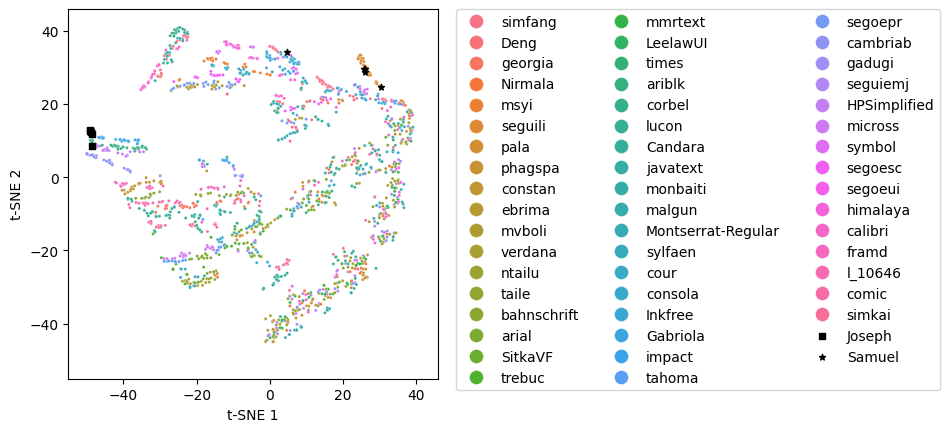

In [101]:
baseline_model.load_state_dict(torch.load("baseline_model/best_model", map_location=torch.device('cpu')))

generate_tsne(baseline_model, fonts_dataset, 30, handwritten_dataset_path='./handwritten')

In [68]:
def generate_confusion_matrix(net, model_name, dataset_path = FONT_DATASET_PATH):
  
    # Load the data
    train_loader, val_loader, test_loader, classes = load_dataset(fonts_dataset)
    confusion_matrix = np.zeros((len(classes), len(classes)))
    net = net.to("cpu")

    with torch.no_grad():

        for i, (inputs, labels) in enumerate(test_loader, 0):
            if i == 100:
                break
                
            # Forward pass
            outputs = net(inputs)
            
            # Find the indices of the max values
            _, indices = torch.max(outputs, dim=1, keepdim=True)
            
            for j in range(len(labels)):
                confusion_matrix[np.argmax(labels[j], axis=0), indices[j]] += 1
    
    plt.figure(figsize=(12,10))
    plt.imshow(confusion_matrix, interpolation='nearest')
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    net = net.to(device)
                
    np.savetxt(f"{model_name}/confusion_matrix.csv", confusion_matrix)
    return confusion_matrix

Done Loading Data


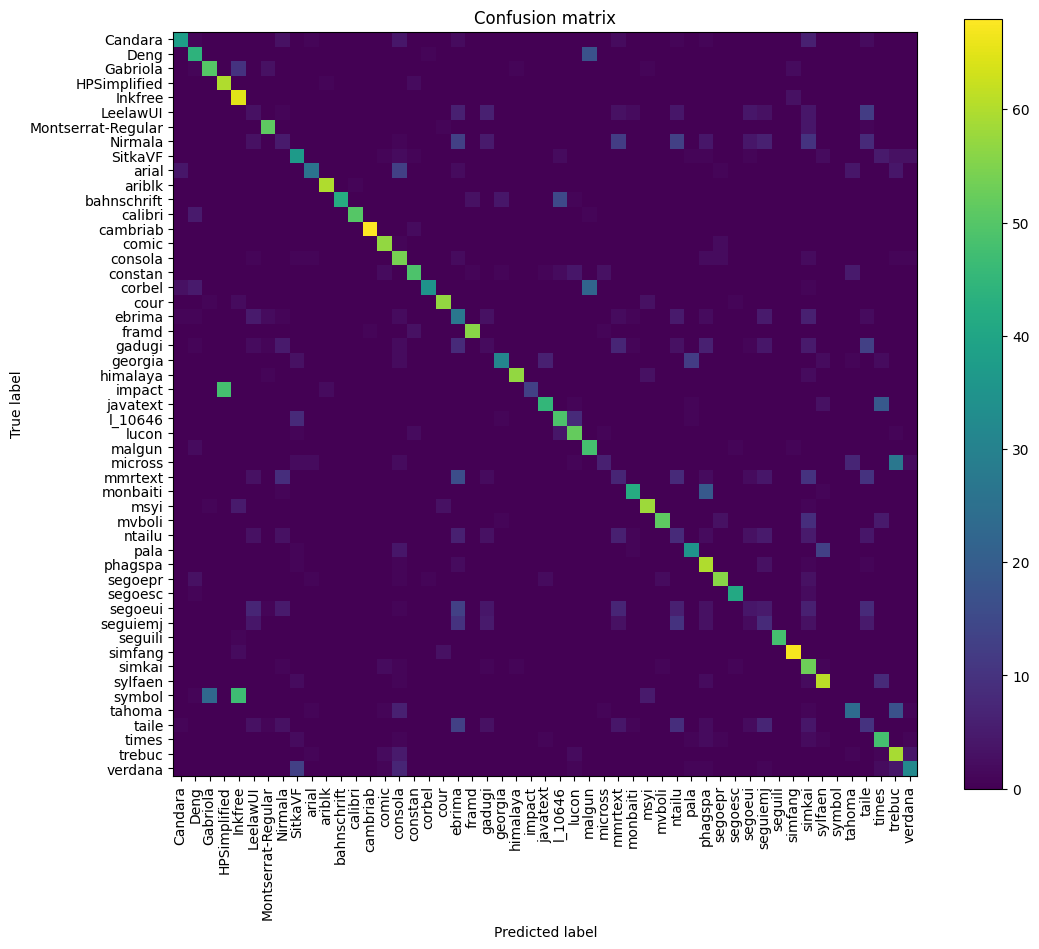

array([[38.,  1.,  0., ...,  0.,  0.,  0.],
       [ 0., 44.,  0., ...,  0.,  0.,  0.],
       [ 0.,  1., 50., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ..., 48.,  0.,  1.],
       [ 0.,  0.,  0., ...,  1., 59.,  4.],
       [ 0.,  0.,  0., ...,  2.,  4., 32.]])

In [69]:
generate_confusion_matrix(baseline_model, "baseline_model")